In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy
from scipy import optimize as op
import corner
import os
from datetime import datetime

In [2]:
os.environ["OMP_NUM_THREADS"]="4"

In [3]:
c=cte.c
Msun=cte.M_sun

In [4]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:
    print(len(rows))
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


9
9
9
9
9
9
9
9
9


In [5]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=(c.to("um/s"))/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [6]:
print((vf*un.Hz).to("GHz"))

[ 148.        218.        278.        599.584916  856.54988  1199.169832] GHz


In [7]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [8]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [9]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [10]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [11]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.e**-TAU * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

In [12]:
frecsT_l=[]
errfT_l=[]
for m in range (len(rows)-1):
    frec=[v1[m],v2[m],v3[m],l1[m],l2[m],l3[m]]
    errf=[ev1[m],ev2[m],ev3[m],el1[m],el2[m],el3[m]]
    frecsT_l.append(frec)
    errfT_l.append(errf)
    

In [13]:
frecs1T=[v1[1],v2[1],v3[1],l1[1],l2[1],l3[1]]
errf1T=[ev1[1],ev2[1],ev3[1],el1[1],el2[1],el3[1]]

In [14]:
frecs1T

[5.54, 26.02, 0.0, 116.35, 104.05, 62.67]

In [15]:
for h in frecs1T:
    if h==0 or h=="NaN":
        print(frecs1T.index(h))
        np.delete(vf,frecs1T.index(h))
        print(np.delete(vf,frecs1T.index(h)))

2
[1.48000000e+11 2.18000000e+11 5.99584916e+11 8.56549880e+11
 1.19916983e+12]


In [16]:
def ml():
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    LT_S=[]
    
    LT_PLnolim=[]
    
    LT_PLlim=[]
    
    
    for j in frecsT_l:
       
        popt,pconv = scipy.optimize.curve_fit(modelSv,vf,j,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
        z_fit,T_fit,M_fit,d_fit = popt
    

        pm = [z_fit,T_fit,M_fit,d_fit]

        y = modelSv(x,pm[0],pm[1],pm[2],pm[3])
                 
        L= [ID[frecsT_l.index(j)],z_fit,T_fit,M_fit,d_fit]
        
        LT_S.append(L)
            

        
    for j in frecsT_l:
       
        popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,j,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
        z_fit,T_fit,M_fit,d_fit = popt
    

        pm = [z_fit,T_fit,M_fit,d_fit]

        y = modelSv(x,pm[0],pm[1],pm[2],pm[3])
                 
        L= [ID[frecsT_l.index(j)],z_fit,T_fit,M_fit,d_fit]
        
        LT_PLnolim.append(L)
        
        
    for j in frecsT_l:
       
        popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,j,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4])) 
    
        z_fit,T_fit,M_fit,d_fit = popt
    

        pm = [z_fit,T_fit,M_fit,d_fit]

        y = modelSv(x,pm[0],pm[1],pm[2],pm[3])
                 
        L= [ID[frecsT_l.index(j)],z_fit,T_fit,M_fit,d_fit]
        
        LT_PLlim.append(L)
    
    z=[]
    T=[]
    M=[]
    d=[]
        
    for a,b,c in zip(LT_S,LT_PLnolim,LT_PLlim):
        z_=[]
        z_.append(a[0]) #para el nombre
        z_.append(a[1])
        z_.append(b[1])
        z_.append(c[1])
        z.append(z_)
        
        T_=[]
        T_.append(a[0]) #para el nombre
        T_.append(a[2])
        T_.append(b[2])
        T_.append(c[2])
        T.append(T_) 
        
        M_=[]
        M_.append(a[0]) #para el nombre
        M_.append(a[3])
        M_.append(b[3])
        M_.append(c[3])
        M.append(M_) 
        
        d_=[]     
        d_.append(a[0]) #para el nombre
        d_.append(a[3])
        d_.append(b[3])
        d_.append(c[3])
        d.append(d_) 
        
    #if interes=="z":  
        #return  z  
    #if interes=="T":  
        #return  T 
    #if interes=="M":  
        #return  M 
    #if interes=="d":  
        #return  d 
                
    return   (LT_S, LT_PLnolim,LT_PLlim) 

In [17]:
ml()

([['ACT-S J0011-0018',
   2.118775374239995,
   44.408370978138635,
   9.686458544024118,
   2.841712920271191],
  ['ACT-S J0022-0155',
   5.316410409367984,
   63.237703362896724,
   8.692939271917625,
   3.965938861365047],
  ['ACT-S J0038_0022',
   3.176385700653448,
   47.778010402921275,
   9.560129049660782,
   3.8113111833970055],
  ['ACT-S J0039+0024',
   2.347650711948744,
   45.93188243677826,
   9.632885785560108,
   3.6150126299426844],
  ['ACT-S J0044+0118',
   5.220141899748941,
   68.7466021860735,
   9.306656587762628,
   3.999887492235874],
  ['ACT-S J0045_0001',
   3.371050014513769,
   46.494132028946794,
   9.686202035154066,
   3.6769879593724135],
  ['ACT-S J0107+0001',
   3.01617366428992,
   44.90201427611956,
   9.43802330409738,
   3.429981695754708],
  ['ACT-S J0116_0004',
   4.093064533506577,
   62.22426974235668,
   9.225878907762079,
   3.9980963184304583]],
 [['ACT-S J0011-0018',
   6.73663999899575,
   84.38526809683152,
   8.509948136345745,
   2.00000

In [18]:
params=[]

for j in range(len(frecsT_l)): #j indica numero de galaxia
        print(j)
    
        theta=[ml()[0][j][1],ml()[0][j][2],ml()[0][j][3],ml()[0][j][4]] 
        
        params.append(theta)
    
    
        print(params[j])
        

0
[2.118775374239995, 44.408370978138635, 9.686458544024118, 2.841712920271191]
1
[5.316410409367984, 63.237703362896724, 8.692939271917625, 3.965938861365047]
2
[3.176385700653448, 47.778010402921275, 9.560129049660782, 3.8113111833970055]
3
[2.347650711948744, 45.93188243677826, 9.632885785560108, 3.6150126299426844]
4
[5.220141899748941, 68.7466021860735, 9.306656587762628, 3.999887492235874]
5
[3.371050014513769, 46.494132028946794, 9.686202035154066, 3.6769879593724135]
6
[3.01617366428992, 44.90201427611956, 9.43802330409738, 3.429981695754708]
7
[4.093064533506577, 62.22426974235668, 9.225878907762079, 3.9980963184304583]


In [19]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_ = theta
    y=np.array(y)
    yerr=np.array(yerr)
    Sv = modelSv(x,z,T,M_,d_)
    Sobs = modelSobs(x,z,T,M_,d_)
    x = x*un.Hz
    if model=="S": 
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike

In [20]:
def lnprior(theta,model):
    z,T,M,d = theta
    if T>0 and z>0 and M>0 and d>0:
        #pM= -1 * (M - 9.4)**2 / (0.24 *10**2) #prior M (sacado de Su)
        #pZ= -1 * (z - 3)**2 / (1 * 10**2) #prior Z 
        #pd= -1 * (d - 4)**2 / (2 * 10**2) #prior T
        if model=="S":
            pT= -1 * (T - 55)**2 / (10 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (10 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (5 * 10**2) #prior Tc
        return pT #pM+pZ+pd+pT
    return -np.inf

In [21]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [22]:
def mcmc_S(model): #recibe con unidades
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    params=[]

    for j in range(len(frecsT_l)-1):
        for (x,y) in zip(frecsT_l,errfT_l): #j indica numero de galaxia
    
            theta=[ml()[0][j][1],ml()[0][j][2],ml()[0][j][3],ml()[0][j][4]] 
        
            params.append(theta)
    
    
            plt.figure(figsize=(12,9))


        
            pm = params[j]

            y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

            ndim, nwalkers = 4, 15 # 15 iteraciones, solo por tiempo, luego serán 1500
            pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 

    
            sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(x),np.array(y),model),
                                threads=4)
            sampler.run_mcmc(pos, 10) #10 chains, por ahora...
            samples = sampler.chain[:, 9:, :].reshape((-1, ndim))
    
            fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[ml()[0][j][1],ml()[0][j][2],ml()[0][j][3],ml()[0][j][4]])

/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ValueError: Probability function returned NaN

<Figure size 864x648 with 0 Axes>

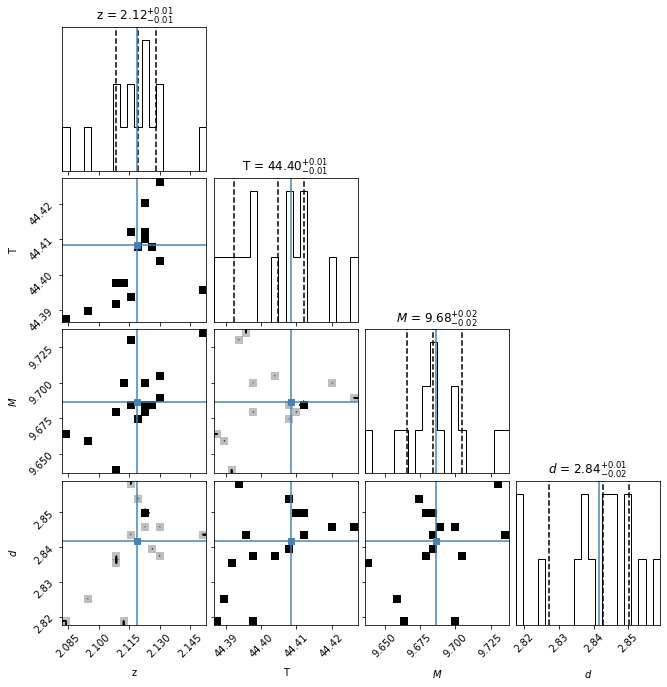

<Figure size 864x648 with 0 Axes>

In [23]:
startTime=datetime.now()
mcmc_S("S")
print(datetime.now()-startTime) 

In [ ]:
def mcmc_PLnolim(ID,frecsT,errfT): #recibe con unidades
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1500 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [ ]:
def mcmc_PLlim(ID,frecsT,errfT): #recibe con unidades
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1500 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])